In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import numpy as np
import astropy.coordinates as coord
import astropy.units as u
from astropy.io import ascii
from astropy.coordinates import SkyCoord
from datetime import datetime
from astropy.table import Table
from astropy.time import Time
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.animation import FuncAnimation
import math
from matplotlib import gridspec
from numba import jit
from celluloid import Camera
import matplotlib.image as mpimg
from mpl_toolkits.basemap import Basemap

In [36]:
def simulateUV(telescopes,
               source,output_name="uvout.mp4", #output filepath for movie
               make_movie=False, #decide whether to create movie
               n_iter=200, #number of iterations
               make_plot=False, #decide whether to plot source
               elev_lim=0, #Elevation limit of the telescope
               obsstart=0, #Observation start in hours of a day
               obsend=24):
    r_e=6731 #Earth Radius in Kilometers
    imgSize=512 #pixelsize of image
    plotLim=15000 #max plot length of baselines
    do_world_map=False #decide whether to show world map or not

    #create real image 
    real_image=np.zeros((imgSize,imgSize))
    #point source in center
    real_image[math.floor(imgSize/2)][math.floor(imgSize/2)]=1
    #point source 2
    #real_image[math.floor(imgSize/2)+20][math.floor(imgSize/2)]=1
    #point source 3
    #real_image[math.floor(imgSize/2)][math.floor(imgSize/2)+20]=1



    #upload custom image
    def rgb2gray(rgb):
        r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
        gray = 0.2989 * r + 0.5870 * g + 0.1140 * b #standard grayscale conversion
        return gray

    img_import = mpimg.imread('../blackhole.png')
    real_image = rgb2gray(img_import)
    #plt.imshow(real_image)
    #plt.show()


    real_image_fft=np.fft.fftshift(np.fft.fft2(real_image))
    #plt.imshow(np.abs(real_image_fft))
    #plt.show()

    #convert hourangle to degrees if need
    for ind,telescope in enumerate(telescopes):
        lat=telescope[0]
        lng=telescope[1]
        if isinstance(lat,str):
            split=lat.split(":")
            telescopes[ind][0]=float(split[0])+float(split[1])/60+float(split[2])/3600
        if isinstance(lng,str):
            split=lng.split(":")
            telescopes[ind][1]=-(float(split[0])+float(split[1])/60+float(split[2])/3600)

    #calculate number of baselines
    n_baselines=int(len(telescopes)*(len(telescopes)-1)/2)


    #calculate u-v transformation matrix from source coordinates
    H=source[0]/180*np.pi
    delta=source[1]/180*np.pi
    matrix=np.array([[np.sin(H),np.cos(H),0],
                     [-np.sin(delta)*np.cos(H),np.sin(delta)*np.sin(H),np.cos(delta)],
                    [np.cos(delta)*np.cos(H),-np.cos(delta)*np.sin(H),np.sin(delta)]])

    colors=['#e6194b', '#3cb44b', '#ffe119', '#4363d8',
            '#f58231', '#911eb4', '#46f0f0', '#f032e6',
            '#bcf60c', '#fabebe', '#008080', '#e6beff',
            '#9a6324', '#fffac8', '#800000', '#aaffc3',
            '#808000', '#ffd8b1', '#000075', '#808080',
            '#000000','#e6194b', '#3cb44b', '#ffe119', '#4363d8',
            '#f58231', '#911eb4', '#46f0f0', '#f032e6',
            '#bcf60c', '#fabebe', '#008080', '#e6beff',
            '#9a6324', '#fffac8', '#800000', '#aaffc3',
            '#808000', '#ffd8b1', '#000075', '#808080',
            '#000000','#e6194b', '#3cb44b', '#ffe119', '#4363d8',
            '#f58231', '#911eb4', '#46f0f0', '#f032e6',
            '#bcf60c', '#fabebe', '#008080', '#e6beff',
            '#9a6324', '#fffac8', '#800000', '#aaffc3',
            '#808000', '#ffd8b1', '#000075', '#808080',
            '#000000','#e6194b', '#3cb44b', '#ffe119', '#4363d8',
            '#f58231', '#911eb4', '#46f0f0', '#f032e6',
            '#bcf60c', '#fabebe', '#008080', '#e6beff',
            '#9a6324', '#fffac8', '#800000', '#aaffc3',
            '#808000', '#ffd8b1', '#000075', '#808080',
            '#000000','#e6194b', '#3cb44b', '#ffe119', '#4363d8',
            '#f58231', '#911eb4', '#46f0f0', '#f032e6',
            '#bcf60c', '#fabebe', '#008080', '#e6beff',
            '#9a6324', '#fffac8', '#800000', '#aaffc3',
            '#808000', '#ffd8b1', '#000075', '#808080',
            '#000000','#e6194b', '#3cb44b', '#ffe119', '#4363d8',
            '#f58231', '#911eb4', '#46f0f0', '#f032e6',
            '#bcf60c', '#fabebe', '#008080', '#e6beff',
            '#9a6324', '#fffac8', '#800000', '#aaffc3',
            '#808000', '#ffd8b1', '#000075', '#808080',
            '#000000','#e6194b', '#3cb44b', '#ffe119', '#4363d8',
            '#f58231', '#911eb4', '#46f0f0', '#f032e6',
            '#bcf60c', '#fabebe', '#008080', '#e6beff',
            '#9a6324', '#fffac8', '#800000', '#aaffc3',
            '#808000', '#ffd8b1', '#000075', '#808080',
            '#000000','#e6194b', '#3cb44b', '#ffe119', '#4363d8',
            '#f58231', '#911eb4', '#46f0f0', '#f032e6',
            '#bcf60c', '#fabebe', '#008080', '#e6beff',
            '#9a6324', '#fffac8', '#800000', '#aaffc3',
            '#808000', '#ffd8b1', '#000075', '#808080',
            '#000000','#e6194b', '#3cb44b', '#ffe119', '#4363d8',
            '#f58231', '#911eb4', '#46f0f0', '#f032e6',
            '#bcf60c', '#fabebe', '#008080', '#e6beff',
            '#9a6324', '#fffac8', '#800000', '#aaffc3',
            '#808000', '#ffd8b1', '#000075', '#808080',
            '#000000','#e6194b', '#3cb44b', '#ffe119', '#4363d8',
            '#f58231', '#911eb4', '#46f0f0', '#f032e6',
            '#bcf60c', '#fabebe', '#008080', '#e6beff',
            '#9a6324', '#fffac8', '#800000', '#aaffc3',
            '#808000', '#ffd8b1', '#000075', '#808080',
            '#000000','#e6194b', '#3cb44b', '#ffe119', '#4363d8',
            '#f58231', '#911eb4', '#46f0f0', '#f032e6',
            '#bcf60c', '#fabebe', '#008080', '#e6beff',
            '#9a6324', '#fffac8', '#800000', '#aaffc3',
            '#808000', '#ffd8b1', '#000075', '#808080',
            '#000000','#e6194b', '#3cb44b', '#ffe119', '#4363d8',
            '#f58231', '#911eb4', '#46f0f0', '#f032e6',
            '#bcf60c', '#fabebe', '#008080', '#e6beff',
            '#9a6324', '#fffac8', '#800000', '#aaffc3',
            '#808000', '#ffd8b1', '#000075', '#808080',
            '#000000','#e6194b', '#3cb44b', '#ffe119', '#4363d8',
            '#f58231', '#911eb4', '#46f0f0', '#f032e6',
            '#bcf60c', '#fabebe', '#008080', '#e6beff',
            '#9a6324', '#fffac8', '#800000', '#aaffc3',
            '#808000', '#ffd8b1', '#000075', '#808080',
            '#000000']


    #convert polar coordinates to cartesian
    @jit(nopython=True)
    def Pol2Cart(r,phi,delta):
        x = r * np.cos(delta/180*np.pi) * np.cos(phi/180*np.pi)
        y = - r * np.cos(delta/180*np.pi) * np.sin(phi/180*np.pi)
        z = r * np.sin(delta/180*np.pi)

        return np.array([x,y,z])

    @jit(nopython=True)
    def getUV(Tel1,Tel2,matrix):
        baseline=Tel2-Tel1

        return np.dot(matrix,baseline)


    source_vector=Pol2Cart(r_e,source[0],source[1])

    u_v_grid=np.zeros((imgSize,imgSize))
    pixelSize=plotLim*2/imgSize

    #create array to save uv_tracks for every baseline
    u_v_tracks=[[[],[]] for x in range(n_baselines)]

    def animate(i,u_v_tracks):

        print(str(i+1)+"/"+str(n_iter),end="\r")
        t=obsstart/24*360+(obsend-obsstart)/24*360/n_iter*i
        #convert all telescope positions to cartesian coordinates
        tels=np.empty(shape=(len(telescopes), 3))
        tel_visible=np.empty(len(telescopes)) #array to store boolean information whether telescope can see the source or not
        for ind,telescope in enumerate(telescopes):
            new_lat=telescope[1]+t
            if new_lat>180:
                new_lat=new_lat-360

            if do_world_map:
                ax=plt.subplot(gs_world,projection="aitoff")
                plt.scatter(new_lat/180*np.pi,telescope[0]/180*np.pi,marker="*",s=400,c="r")

            tel=Pol2Cart(r_e,new_lat,telescope[0])
            tels[ind]=tel

            #determine whether source is visible to telescope
            if np.dot(tel,source_vector)/r_e**2<np.cos((90-elev_lim)/180*np.pi):
                tel_visible[ind]=False
            else:
                tel_visible[ind]=True



        baseline_count=0
        for k in range(len(tels)):
            if k<len(tels)-1:
                for j in range(k+1,len(tels)):
                    if tel_visible[k] and tel_visible[j]:

                        #plot baseline in world map
                        if do_world_map:
                            ax=plt.subplot(gs_world)
                            plt.plot([(telescopes[k][1]+t)/180*np.pi,(telescopes[j][1]+t)/180*np.pi],
                                     [(telescopes[k][0])/180*np.pi,(telescopes[j][0])/180*np.pi],
                                     c=colors[baseline_count])

                        #get new u_v data point
                        baseline_uv=getUV(tels[k],tels[j],matrix)
                        u=baseline_uv[0]
                        v=baseline_uv[1]

                        #append new u_v point to baseline u_v track
                        u_array=u_v_tracks[baseline_count][0].append(u)
                        v_array=u_v_tracks[baseline_count][1].append(v)

                        #change u_v_sampling grid
                        x_ind=math.floor((u+plotLim)/pixelSize)
                        y_ind=math.floor((v+plotLim)/pixelSize)

                        u_v_grid[y_ind][x_ind]=1

                        x_ind=math.floor((-u+plotLim)/pixelSize)
                        y_ind=math.floor((-v+plotLim)/pixelSize)

                        u_v_grid[y_ind][x_ind]=1

                        if make_plot or make_movie: 
                            #plot current status of uv_tracks
                            u_plot=u_v_tracks[baseline_count][0]
                            v_plot=u_v_tracks[baseline_count][1]
                            ax = plt.subplot(gs_uv)
                            plt.scatter(u_plot,v_plot,c=colors[baseline_count],s=1)
                            plt.scatter(-np.array(u_plot),-np.array(v_plot),c=colors[baseline_count],s=1)
                            
                    baseline_count+=1
        
        if make_plot or make_movie:                
            ax=plt.subplot(gs_image)
            u_v_grid_new=u_v_grid*real_image_fft
            new_dirty_image=np.abs(np.fft.ifft2(np.fft.fftshift(u_v_grid_new)))
            plt.imshow(new_dirty_image,cmap="inferno")

            camera.snap()
        return u_v_tracks

    if do_world_map:
        fig = plt.figure(figsize=(24,8))
        gs=gridspec.GridSpec(1,3,height_ratios=[1])
        gs_world=gs[0]
        gs_uv=gs[1]
        gs_image=gs[2]
    elif make_plot or make_movie:
        fig = plt.figure(figsize=(16,8))
        gs=gridspec.GridSpec(1,2,height_ratios=[1])
        gs_uv=gs[0]
        gs_image=gs[1]
    
    if make_plot or make_movie:
        camera = Camera(fig)
        ax = plt.subplot(gs_uv)

        plt.xlabel("u [km]")
        plt.ylabel("v [km]")
        plt.ylim(-plotLim,plotLim)
        plt.xlim(-plotLim,plotLim)

    if do_world_map:
        ax=plt.subplot(gs_world,projection="aitoff")
        plt.grid(True)

    #anim=FuncAnimation(fig, animate, frames=n_iter, repeat=False,cache_frame_data=False)
    #anim.save('uvcover.mp4', writer = 'ffmpeg', fps = 4)

    for i in range(n_iter):
        u_v_tracks=animate(i,u_v_tracks)

    if make_movie:
        anim = camera.animate(blit=True)
        anim.save(output_name, writer='ffmpeg')
    
    if make_plot:
        plt.show()
    
    return u_v_tracks

def plotUVdata(uv_coverage,highlight_baselines=[]):
    
    for baseline_count in range(len(uv_coverage)):
        
        if baseline_count in highlight_baselines:
            color="red"
        else:
            color="black"
        
        u_plot=uv_coverage[baseline_count][0]
        v_plot=uv_coverage[baseline_count][1] 
        plt.scatter(-np.array(u_plot),v_plot,c=color,s=0.1)
        plt.scatter(u_plot,-np.array(v_plot),c=color,s=0.1)
        plt.xlabel("u [km]")
        plt.ylabel("v [km]")
        
def plotMap(telescopes):
    
    #convert hourangle to degrees if need
    for ind,telescope in enumerate(telescopes):
        lat=telescope[0]
        lng=telescope[1]
        if isinstance(lat,str):
            split=lat.split(":")
            telescopes[ind][0]=float(split[0])+float(split[1])/60+float(split[2])/3600
        if isinstance(lng,str):
            split=lng.split(":")
            telescopes[ind][1]=-(float(split[0])+float(split[1])/60+float(split[2])/3600)
    
    m = Basemap(projection='cyl',llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=-180,urcrnrlon=180,resolution='c')
    m.etopo(scale=0.5, alpha=0.5)

    # Map (long, lat) to (x, y) for plotting
    for telescope in telescopes:
        x, y = m(telescope[1],telescope[0])
        plt.plot(x, y, 'ok', markersize=5)
        
def getHighlightBaselines(telescopes,inds):
        
    n_baselines=int(len(telescopes)*(len(telescopes)-1)/2)
    
    highlight_baselines=[]
    
    baseline_count=0
    for k in range(len(telescopes)):
        if k<len(telescopes)-1:
            for j in range(k+1,len(telescopes)):
                if (j in inds) or (k in inds):
                    highlight_baselines.append(baseline_count)
                baseline_count+=1
    
    return highlight_baselines

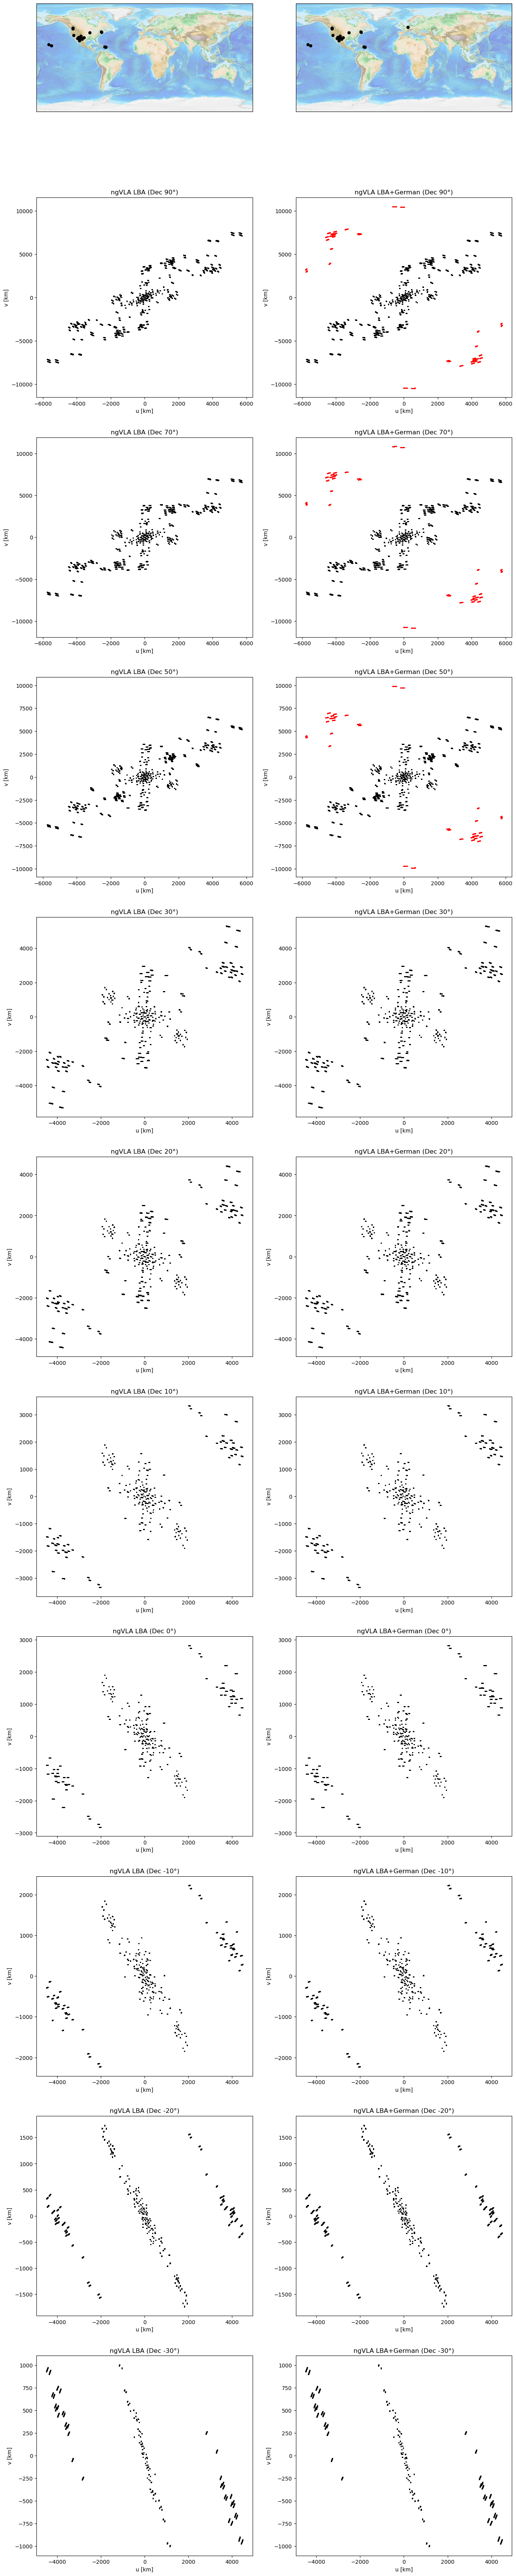

In [37]:
#define custom telescopes
telescopes=[[50.1905748,11.789879],[49.783333,9.933333],[48.137154,11.576124]]

vlba=[[42.93362, -71.98681],[41.77165, -91.574133],[30.635214, -103.944826],
        [35.775289, -106.24559],[34.30107, -108.11912],[31.956253, -111.612361],
        [37.23176, -118.27714],[48.13117, -119.68325],[19.80159, -155.45581],[17.75652, -64.58376]]

ngVLA_LBA=[["17:45:24","064:35:01"],["18:20:39","066:45:10"],["42:56:01","071:59:12"],
            ["41:46:17","091:34:27"],["30:38:06","103:56:41"],["35:46:30","106:14:44"],
            ["34:18:04","108:07:09"],["31:57:23","111:36:45"],["37:13:54","118:16:37"],
            ["48:07:52","119:41:00"],["49:18:00","119:36:00"],["19:48:05","155:27:20"],
            ["22:07:36","159:39:54"],["42:36:47","071:29:38"],["34:04:59","107:38:24"],
            ["33:12:34","106:03:15"],["33:28:20","101:12:18"],["31:57:17","108:33:54"],
            ["28:24:56","108:21:36"],["34:07:43","110:05:59"]]

ngVLA_LBA_german=[["17:45:24","064:35:01"],["18:20:39","066:45:10"],["42:56:01","071:59:12"],
            ["41:46:17","091:34:27"],["30:38:06","103:56:41"],["35:46:30","106:14:44"],
            ["34:18:04","108:07:09"],["31:57:23","111:36:45"],["37:13:54","118:16:37"],
            ["48:07:52","119:41:00"],["49:18:00","119:36:00"],["19:48:05","155:27:20"],
            ["22:07:36","159:39:54"],["42:36:47","071:29:38"],["34:04:59","107:38:24"],
            ["33:12:34","106:03:15"],["33:28:20","101:12:18"],["31:57:17","108:33:54"],
            ["28:24:56","108:21:36"],["34:07:43","110:05:59"],[50.523800, 6.884231]]#,[50.979389, 11.710282],[48.500623, 11.287344]]


#set telescope preset
telescopes=ngVLA_LBA
telescopes2=ngVLA_LBA_german

#plot Antenna locations on map

fig = plt.figure(figsize=(16, 88))
gs = gridspec.GridSpec(11,2,height_ratios=[1,1,1,1,1,1,1,1,1,1,1],width_ratios=[1,1])

ax=plt.subplot(gs[0,0])

plotMap(telescopes)

ax=plt.subplot(gs[0,1])

plotMap(telescopes2)


#plot UV coverages for different declinations

for i,declination in enumerate([90,70,50,30,20,10,0,-10,-20,-30]):
    
    source=[0,declination] #source position in ra dec
    
    uv_coverage1=simulateUV(telescopes,source,n_iter=1000,elev_lim=5,obsstart=11,obsend=11.083)
    uv_coverage2=simulateUV(telescopes2,source,n_iter=1000,elev_lim=5,obsend=11,obsstart=11.083)
    

    ax=plt.subplot(gs[i+1,0])
    
    plotUVdata(uv_coverage1)
    plt.xlabel("u [km]")
    plt.ylabel("v [km]")
    plt.title("ngVLA LBA (Dec "+ str(declination) +"°)")
        
    ax=plt.subplot(gs[i+1,1])
    
    #plot uv coverage and highlight german stations
    highlight_baselines=getHighlightBaselines(telescopes2,[20,21,22])
    plotUVdata(uv_coverage2,highlight_baselines=highlight_baselines)
    
    plt.xlabel("u [km]")
    plt.ylabel("v [km]")
    plt.title("ngVLA LBA+German (Dec "+ str(declination) +"°)")
    
    plt.subplot(gs[i+1,0]).set_ylim(ax.get_ylim())
    plt.subplot(gs[i+1,0]).set_xlim(ax.get_xlim())

plt.savefig("UV_plots_oneGerman_snap5min.png",dpi=100)
plt.show()
      
    
    


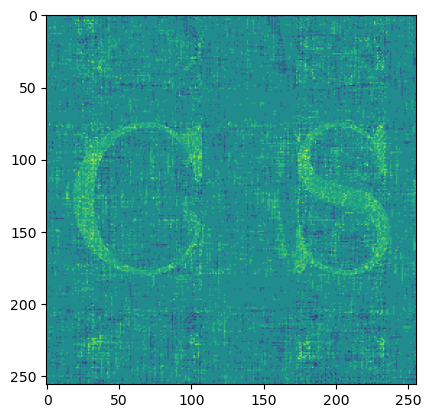

In [24]:
#upload custom image
def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b #standard grayscale conversion
    return gray

img_import = mpimg.imread('canvas.png')
real_image = rgb2gray(img_import)
#plt.imshow(real_image)
#plt.show()


real_image_fft=np.fft.fftshift(np.fft.fft2(real_image))
#plt.imshow(np.abs(real_image_fft))
#plt.show()

real_image_back=np.abs(np.fft.ifft2(np.fft.fftshift(real_image_fft)))
plt.imshow(real_image_back-real_image)
